<a href="https://colab.research.google.com/github/erogluegemen/Recommendation-System-with-GPU/blob/main/Content_based_Recommendation_with_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Content-based Recommendation with GPU

**Important Note**

[RAPIDS CUML Documentation](https://docs.rapids.ai/api/cuml/stable/api/)

> **_NOTE:_**  The ‘jaccard’ distance metric is only supported for **sparse** inputs.

# The Logic Behind GPU Accelerated KNN

All the optimizations we've done so far are just making the **CPU** work more efficiently(maybe with some parallelism or concurrency).

To use a **GPU**, entire problem must be reframed w.r.t the language of **linear algebra** (matrices and vectors). GPUs are designed to perform thousands of simple math operations (like *ADD* and *MUL*) at the same time, which is what matrix operations are.

## The Key: The RAPIDS Ecosystem

* **`cuDF`**: This is _pandas on the GPU._ We gonna use it to create DataFrames that live in the GPU's memory.

* **`cuML`**: This is _scikit-learn on the GPU._ It has incredible fast, GPU supported versions of common algorithms, including KNN.

* **`CuPy`**: This is _NumPy on the GPU._

## How Problem Changes for a GPU

### 1. Data

**CPU (what we had):**
```python
{1: {'Animation', 'Children', 'Comedy'}}
```

**GPU (what we will build, binary multi ohe matrix):**
| movieId | Action | Adventure | Animation | Children | Comedy | ... |
| :--- | :---: | :---: | :---: | :---: | :---: | :---: |
| 1 | 0 | 0 | 1 | 1 | 1 | ... |
| 2 | 0 | 1 | 0 | 1 | 0 | ... |
| 3 | 0 | 0 | 0 | 0 | 1 | ... |

This matrix **$G$**, is fully numerical and perfect for GPU.

### 2. KNN: From $O(N^2)$ Loops to Matrix Multiplication

CPU function calculates approx. 47 million Jaccard similarities one by one. On a GPU, we do it *all at once* using matrix algebra.

#### **Intersection Matrix ($I$)**
The number of shared genres between *all* pairs of movies is calculated in one operation:

$$ I = G \cdot G^T $$

* The resulting matrix $I$ (size $9742 \times 9742$) will have $I_{ij}$ = the intersection size (shared genre count) between movie $i$ and movie $j$.

#### **Union Size Matrix ($U$)**
First, we get a vector $C$ of the genre counts for each movie (the sum of each row in $G$).

$$ C_i = \sum_{k} G_{ik} $$

The union size for any two movies $i$ and $j$ is $\text{Union} = |A| + |B| - \text{Intersection}$. We can build the full $9742 \times 9742$ union matrix $U$ like this:

$$ U_{ij} = C_i + C_j - I_{ij} $$

This is also a single, fast GPU operation.

#### **Jaccard Similarity Matrix ($S$)**
Finally, the Jaccard similarity is the intersection divided by the union. We can do this for the *entire matrix* at once:

$$ S = \frac{I}{U} $$

In just 3 steps, we have the similarity score for every movie mapped to every other movie.

## NVIDIA GPU RAPIDS CONFIG

In [1]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

!bash rapidsai-csp-utils/colab/install.sh

import sys
sys.path.append('/usr/local/lib/python3.10/site-packages/')

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 603, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 603 (delta 131), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (603/603), 199.38 KiB | 8.31 MiB/s, done.
Resolving deltas: 100% (305/305), done.
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS via pip!  Please stand by, should be quick...
***********************************************************************

bash: rapidsai-csp-utils/colab/install.sh: No such file or directory


## LIBRARIES

In [2]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import cudf
import cupy as cp

import scipy.sparse
import cupyx.scipy.sparse as cupy_sparse
from cuml.neighbors import NearestNeighbors

## SETUP

In [8]:
PATH = "/content/drive/MyDrive/Recommendation_Systems/datasets/movies.csv"
movies_cpu = pd.read_csv(filepath_or_buffer=PATH, sep=",")
movies_cpu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [14]:
K = 10
PATH = "/content/drive/MyDrive/Recommendation_Systems/datasets/movies.csv"
movies_cpu = pd.read_csv(filepath_or_buffer=PATH, sep=",")

# Encode
genres_cpu = movies_cpu['genres'].str.get_dummies(sep='|')
genres_cpu.index = movies_cpu['movieId']

print(f"Genre matrix shape: {genres_cpu.shape}")
display(genres_cpu.head(3))

Genre matrix shape: (9742, 20)


,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


## DATA TRANSFORMATION

In [15]:
print(f"Original dense CPU shape: {genres_cpu.shape}")

print("\nConverting CPU pandas -> CPU sparse")
genres_sparse_cpu = scipy.sparse.csr_matrix(genres_cpu.values, dtype='bool')

print("\nTransferring CPU sparse -> GPU sparse")
start_transfer = time.time()

G_gpu_sparse = cupy_sparse.csr_matrix(genres_sparse_cpu)

end_transfer = time.time()
print(f"Transfer time: {end_transfer - start_transfer:.4f} seconds")

print(f"\nType of G_gpu_sparse: {type(G_gpu_sparse)}")
print(f"Shape of G_gpu_sparse: {G_gpu_sparse.shape}")
print(f"Dtype of G_gpu_sparse: {G_gpu_sparse.dtype}")

Original dense CPU shape: (9742, 20)

Converting CPU pandas -> CPU sparse

Transferring CPU sparse -> GPU sparse
Transfer time: 0.0010 seconds

Type of G_gpu_sparse: <class 'cupyx.scipy.sparse._csr.csr_matrix'>
Shape of G_gpu_sparse: (9742, 20)
Dtype of G_gpu_sparse: bool


## BUILD KNN

In [16]:
print(f"Starting GPU KNN build for K={K}")

knn_model = NearestNeighbors(n_neighbors=K+1, metric='jaccard', algorithm='brute')

start_fit = time.time()
print(f"\nFitting model with sparse input...")
knn_model.fit(G_gpu_sparse)

end_fit = time.time()
print(f"\nGPU fit time: {end_fit - start_fit:.4f} seconds")

start_query = time.time()
distances, indices = knn_model.kneighbors(G_gpu_sparse)
end_query = time.time()
print(f"GPU query time: {end_query - start_query:.4f} seconds")

print("\nGPU KNN Complete")
print("Distances shape:", distances.shape)
print("Indices shape:", indices.shape)

Starting GPU KNN build for K=10

Fitting model with sparse input...

GPU fit time: 0.0025 seconds
GPU query time: 0.0377 seconds

GPU KNN Complete
Distances shape: (9742, 11)
Indices shape: (9742, 11)


## TEST MODEL

In [24]:
indices_cpu = indices.get()
distances_cpu = distances.get()

index_to_movieid_map = dict(enumerate(genres_cpu.index))
title_map = movies_cpu.set_index('movieId')['title'].to_dict()

knn_map_with_names = {}
for row_index, neighbor_indices in enumerate(indices_cpu):
    source_movie_id = index_to_movieid_map[row_index]
    source_movie_title = title_map.get(source_movie_id, f"ID:{source_movie_id}")
    neighbor_movie_ids = [index_to_movieid_map[n] for n in neighbor_indices[1:]]
    neighbor_scores = [float(1.0 - d) for d in distances_cpu[row_index][1:]]
    neighbor_titles = [title_map.get(mid, f"ID:{mid}") for mid in neighbor_movie_ids]
    knn_map_with_names[source_movie_title] = list(zip((neighbor_scores), neighbor_titles))

print("Testing results")
toy_story_key = title_map[1]
print(f"Top 5 neighbors for {toy_story_key}:")
for i in range(6):
  print(knn_map_with_names[toy_story_key][i])

Testing results
Top 5 neighbors for Toy Story (1995):
(1.0, 'Asterix and the Vikings (Astérix et les Vikings) (2006)')
(1.0, 'Wild, The (2006)')
(1.0, 'Toy Story 2 (1999)')
(1.0, 'Adventures of Rocky and Bullwinkle, The (2000)')
(1.0, 'Tale of Despereaux, The (2008)')
(1.0, 'Moana (2016)')


## VISUALIZATION

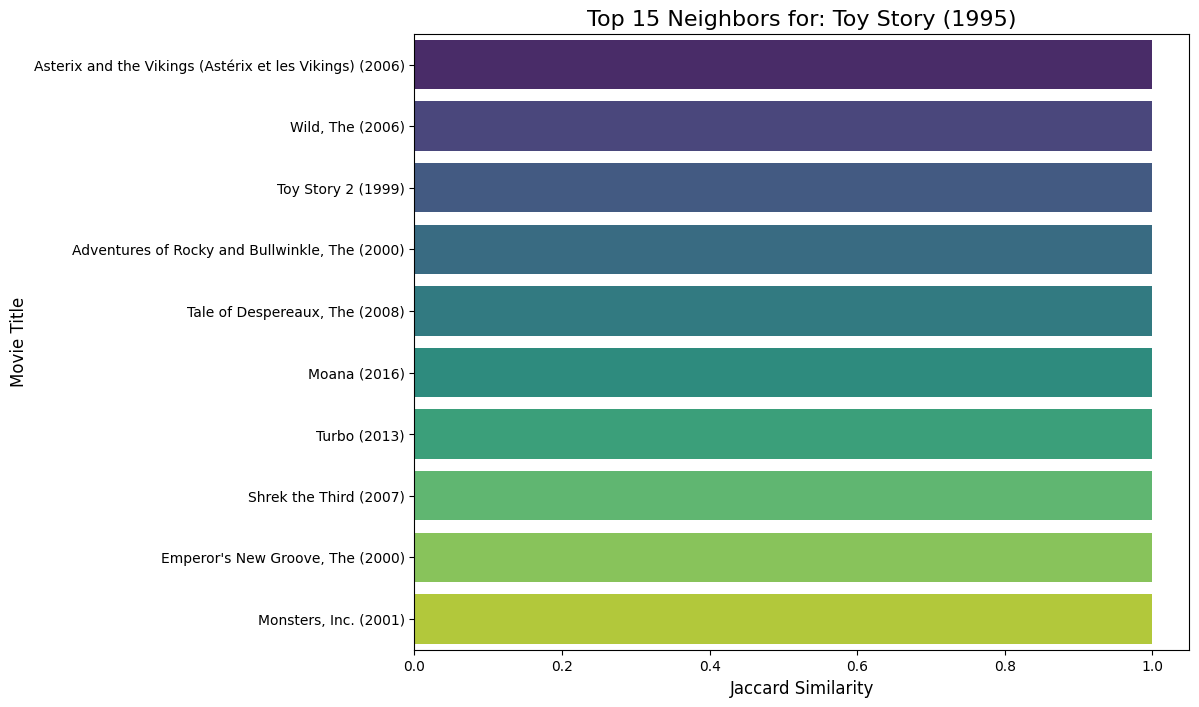

In [20]:
movie_title = 'Toy Story (1995)'

data = knn_map_with_names.get(movie_title, [])

neighbors_df = pd.DataFrame(data, columns=['similarity', 'title']).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(
  x='similarity',
  y='title',
  data=neighbors_df,
  palette='viridis',
  hue='title',
  legend=False,
)

plt.title(f"Top 10 Neighbors for: {movie_title}", fontsize=16)
plt.xlabel("Jaccard Similarity", fontsize=12)
plt.ylabel("Movie Title", fontsize=12)
plt.show()